## Full data

In [1]:
import os
import cv2
import sys
import random
import rasterio
import numpy as np
import tifffile as tiff
import matplotlib.image as mpimg
import rasterio 
from skimage.transform import rescale, resize

from keras import backend as K
from keras.layers import Conv2D
from keras import layers
from keras.models import Model

from matplotlib import pyplot as plt
from keras.optimizers import SGD, Adam, RMSprop
from keras.backend import categorical_crossentropy, binary_crossentropy
from segmentation_models import Unet, FPN
from segmentation_models.utils import set_trainable

from keras.callbacks import ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import TensorBoard
from keras.callbacks import CSVLogger
from keras.callbacks import EarlyStopping

#os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = "1"

Using TensorFlow backend.
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarn

Segmentation Models: using `keras` framework.


In [2]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

## 3 channels

'0_0.tif', '0_1.tif', '0_2.tif', '0_3.tif', '1_0.tif', '1_1.tif', '1_2.tif', '1_3.tif', '1_4.tif', '2_1.tif', '2_2.tif', '2_3.tif', '2_4.tif', '2_5.tif', '2_6.tif', '2_7.tif', '2_8.tif', '3_1.tif', '3_2.tif', '3_3.tif', '3_4.tif', '3_5.tif', '3_6.tif', '3_7.tif', '3_8.tif', '3_9.tif', '4_1.tif', '4_2.tif', '4_3.tif', '4_4.tif', '4_5.tif', '4_6.tif', '4_7.tif', '4_8.tif', '4_9.tif', '5_1.tif', '5_2.tif', '5_3.tif', '5_4.tif', '5_5.tif', '5_6.tif', '5_7.tif', '5_8.tif', '6_3.tif', '6_4.tif', '6_5.tif', '6_6.tif', '6_7.tif', '7_3.tif', '7_4.tif', '7_5.tif','7_6.tif', '7_7.tif', '8_5.tif', '8_6.tif', '9_5.tif', '9_6.tif'

### Split on test, train, validation

In [3]:
os.listdir('/home/user/data/EO_Browser_images')

['.ipynb_checkpoints', '3', '2', '0', '1']

In [4]:
from random import seed
seed(6)
aoi_list = ['0_0.tif', '0_1.tif', '0_2.tif', '0_3.tif', '1_0.tif', '1_1.tif', '1_2.tif', '1_3.tif', '1_4.tif', '2_1.tif', '2_2.tif', '2_3.tif', '2_4.tif', '2_5.tif', '2_6.tif', '2_7.tif', '2_8.tif', '3_1.tif', '3_2.tif', '3_3.tif', '3_4.tif', '3_5.tif', '3_6.tif', '3_7.tif', '3_8.tif', '3_9.tif', '4_1.tif', '4_2.tif', '4_3.tif', '4_4.tif', '4_5.tif', '4_6.tif', '4_7.tif', '4_8.tif', '4_9.tif', '5_1.tif', '5_2.tif', '5_3.tif', '5_4.tif', '5_5.tif', '5_6.tif', '5_7.tif', '5_8.tif', '6_3.tif', '6_4.tif', '6_5.tif', '6_6.tif', '6_7.tif', '7_3.tif', '7_4.tif', '7_5.tif','7_6.tif', '7_7.tif', '8_5.tif', '8_6.tif', '9_5.tif', '9_6.tif']
aoi_list = [k.split('.')[0] for k in aoi_list]
train_list_split = random.sample(aoi_list, k=41)
test_list_split = random.sample([k for k in aoi_list if k not in train_list_split], k=8)
val_list_split = random.sample([k for k in aoi_list if k not in test_list_split and k not in train_list_split], k=8)

print(train_list_split)
print(test_list_split)
print(val_list_split)

train_img_list = []
test_img_list = []
val_img_list = []

# Mandrog
for folder in [0, 1]:
    for file_name in os.listdir('/home/user/data/EO_Browser_images/{}'.format(folder)):
        if file_name[:3] in train_list_split and '/home/user/data/EO_Browser_images/{}/{}'.format(folder, file_name[:3]) not in train_img_list:
            train_img_list += ['/home/user/data/EO_Browser_images/{}/{}'.format(folder, file_name[:3])]
        elif file_name[:3] in test_list_split and '/home/user/data/EO_Browser_images/{}/{}'.format(folder, file_name[:3]) not in test_img_list:
            test_img_list += ['/home/user/data/EO_Browser_images/{}/{}'.format(folder, file_name[:3])]
        elif file_name[:3] in val_list_split and '/home/user/data/EO_Browser_images/{}/{}'.format(folder, file_name[:3]) not in val_img_list:
            val_img_list += ['/home/user/data/EO_Browser_images/{}/{}'.format(folder, file_name[:3])]

['7_5', '5_2', '7_7', '1_1', '4_6', '7_3', '2_8', '0_2', '0_0', '2_1', '5_8', '5_3', '4_5', '3_7', '3_4', '0_1', '3_1', '8_6', '2_4', '4_1', '4_9', '9_5', '1_2', '5_4', '9_6', '8_5', '4_2', '2_5', '2_2', '7_4', '2_3', '3_9', '4_4', '1_4', '2_6', '0_3', '5_1', '6_7', '3_5', '5_7', '6_6']
['5_6', '4_3', '6_4', '3_2', '4_7', '4_8', '7_6', '1_0']
['5_5', '2_7', '3_8', '3_6', '3_3', '6_3', '1_3', '6_5']


## Compute statistics

In [5]:
aspen_stat = 0
birch_stat = 0
pine_stat = 0
spruce_stat = 0

for dse_path in train_img_list:
    aspen_stat += np.sum(tiff.imread(dse_path + '_class_Os.tif')>0.5)
    birch_stat += np.sum(tiff.imread(dse_path + '_class_B.tif')>0.5)
    pine_stat += np.sum(tiff.imread(dse_path + '_class_S.tif')>0.5)
    spruce_stat += np.sum(tiff.imread(dse_path + '_class_E.tif')>0.5)

In [6]:
print('aspen: ', aspen_stat, round(aspen_stat/(aspen_stat+birch_stat+pine_stat+spruce_stat),3))
print('birch: ', birch_stat, round(birch_stat/(aspen_stat+birch_stat+pine_stat+spruce_stat),3))
print('pine: ', pine_stat, round(pine_stat/(aspen_stat+birch_stat+pine_stat+spruce_stat),3))
print('spruce: ', spruce_stat, round(spruce_stat/(aspen_stat+birch_stat+pine_stat+spruce_stat),3))
print('~~~~~~~~~~~~~~~~~~~~~~~~~')
print('deciduous: ', aspen_stat+birch_stat, round((aspen_stat+birch_stat)/(aspen_stat+birch_stat+pine_stat+spruce_stat),3))
print('conifer: ', pine_stat+spruce_stat, round((pine_stat+spruce_stat)/(aspen_stat+birch_stat+pine_stat+spruce_stat),3))

aspen:  886632 0.172
birch:  1385786 0.268
pine:  993156 0.192
spruce:  1901716 0.368
~~~~~~~~~~~~~~~~~~~~~~~~~
deciduous:  2272418 0.44
conifer:  2894872 0.56


### Set path to data

In [7]:
IMG_ROW=IMG_COL=64
IMG_CHANNEL=13

In [8]:
import scipy
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
from random import seed
from rasterio.windows import Window

In [9]:
age_flag = True

In [16]:
def get_img_mask_array(imgpath, num_channels=9, num_classes=2):
    with rasterio.open(imgpath + '_channel_01.tif') as src:
        size_x = src.width
        size_y = src.height
    
    rnd_x = random.randint(0,size_x -  IMG_ROW - 1)
    rnd_y = random.randint(0,size_y - IMG_COL - 1)
    window = Window(rnd_x, rnd_y, IMG_COL, IMG_ROW)
    
    img = np.ones((IMG_ROW, IMG_COL, num_channels), dtype=np.float)
    with rasterio.open(imgpath+ '_channel_{}.tif'.format('01')) as src:
        img[:,:,0] = src.read(window=window)
    # remove black area
    while np.count_nonzero(img[:,:,0]) < IMG_ROW*IMG_COL*3/5. or np.sum(np.where(img[:,:,0]==255,1,0)) > IMG_ROW*IMG_COL*3/5.:
        rnd_x = random.randint(0,size_x -  IMG_ROW - 1)
        rnd_y = random.randint(0,size_y - IMG_COL - 1)
        window = Window(rnd_x, rnd_y, IMG_COL, IMG_ROW)
        with rasterio.open(imgpath+ '_channel_{}.tif'.format('01')) as src:
            img[:,:,0] = src.read(window=window)
    
    for i in range(1, num_channels-1-age_flag): #-2
        i_ch =  i + 1
        if i < 9:
            i_ch = '0' + str(i+1)
        with rasterio.open(imgpath+ '_channel_{}.tif'.format(i_ch)) as src:
            img[:,:,i] = src.read(window=window)
    
    with rasterio.open(imgpath+ '_channel_{}.tif'.format('8A')) as src:
        img[:,:,-1-age_flag] = src.read(window=window)   #-2
    
    img /= 255.
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # AGE
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    if age_flag:
        channel_name = '_age.tif'
        with rasterio.open(imgpath + channel_name) as src:
            img[:,:,-1] = src.read(window=window).astype(np.float)
        img[:,:,-1] = (img[:,:,-1] / 100.).clip(0., 1.)

    # write classes
    mask = np.ones((IMG_ROW, IMG_COL, num_classes)) 
    with rasterio.open(imgpath + '_class_Os.tif') as src:
        mask_0 = src.read(window=window).astype(np.float)
    with rasterio.open(imgpath + '_class_B.tif') as src:
        mask_1 = src.read(window=window).astype(np.float)
    with rasterio.open(imgpath + '_class_E.tif') as src:
        mask_2 = src.read(window=window).astype(np.float)
    with rasterio.open(imgpath + '_class_S.tif') as src:
        mask_3 = src.read(window=window).astype(np.float)
    
    mask_conifer = mask_2 + mask_3
    mask_deciduous = mask_0 + mask_1 
    for i in range(num_classes):
        mask[:,:,i] = np.where(np.argmax([mask_conifer, mask_deciduous], axis=0)==i, 1, 0) \
            * np.where(np.sum([mask_conifer, mask_deciduous], axis=0) != 0, 1, 0) 
   
    return np.asarray(img), np.asarray(mask)  

In [45]:
# _class_E _class_S _class_Os _class_B
def get_img_mask_array(imgpath, num_channels=13, num_classes=2, class_name='S'):
    with rasterio.open(imgpath + '_channel_01.tif') as src:
        size_x = src.width
        size_y = src.height
    
    rnd_x = random.randint(0,size_x -  IMG_ROW - 1)
    rnd_y = random.randint(0,size_y - IMG_COL - 1)
    window = Window(rnd_x, rnd_y, IMG_COL, IMG_ROW)
    
    img = np.ones((IMG_ROW, IMG_COL, num_channels), dtype=np.float)
    with rasterio.open(imgpath+ '_channel_01.tif') as src:
        img[:,:,0] = src.read(window=window)
            
    with rasterio.open(imgpath + '_class_{}.tif'.format(class_name)) as src: 
        mask_0 = src.read(window=window).astype(np.float)
        mask_0 = np.where(mask_0 > 0.5, 1, 0)
    
    mask_1 = np.zeros((1, IMG_ROW, IMG_COL))
    for cl_name in ['S', 'B', 'E', 'Os']:
        with rasterio.open(imgpath + '_class_{}.tif'.format(cl_name)) as src:
            mask_1 += (src.read(window=window).astype(np.float)>0.5)
                
    # remove black area
    while np.sum(mask_1) < IMG_ROW*IMG_COL / 10 or np.count_nonzero(img[:,:,0]) < IMG_ROW*IMG_COL*3/5.:
        rnd_x = random.randrange(0,size_x -  IMG_ROW - 1) #random.randrange random.randint
        rnd_y = random.randrange(0,size_y - IMG_COL - 1)
        window = Window(rnd_x, rnd_y, IMG_COL, IMG_ROW)
        with rasterio.open(imgpath+ '_channel_01.tif') as src:
            img[:,:,0] = src.read(window=window)
        with rasterio.open(imgpath + '_class_{}.tif'.format(class_name)) as src:
            mask_0 = src.read(window=window).astype(np.float)
        mask_0 = np.where(mask_0 > 0.5, 1, 0)
        mask_1 = np.zeros((1, IMG_ROW, IMG_COL))
        for cl_name in ['S', 'B', 'E', 'Os']:
            with rasterio.open(imgpath + '_class_{}.tif'.format(cl_name)) as src:
                mask_1 += (src.read(window=window).astype(np.float)>0.5)

            
    for i in range(1, num_channels-1-age_flag): #-2
        i_ch =  i + 1
        if i < 9:
            i_ch = '0' + str(i+1)
        with rasterio.open(imgpath+ '_channel_{}.tif'.format(i_ch)) as src:
            img[:,:,i] = src.read(window=window)
    
    with rasterio.open(imgpath+ '_channel_{}.tif'.format('8A')) as src:
        img[:,:,-1-age_flag] = src.read(window=window)  #-2

    img /= 255.
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # AGE
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    if age_flag:
        channel_name = '_age.tif'
        with rasterio.open(imgpath + channel_name) as src:
            img[:,:,-1] = src.read(window=window).astype(np.float)
        img[:,:,-1] = (img[:,:,-1] / 100.).clip(0., 1.)
    # OTHER CLASSES
    mask_1 = np.zeros((1, IMG_ROW, IMG_COL))
    for cl_name in ['S', 'B', 'E', 'Os']:
        if cl_name == class_name:
            continue
        else:
            with rasterio.open(imgpath + '_class_{}.tif'.format(cl_name)) as src:
                mask_1 += (src.read(window=window).astype(np.float)>0.5)
    
    mask = np.ones((IMG_ROW, IMG_COL, num_classes)) 
    mask[:,:,0] = mask_0  
    mask[:,:,1] = mask_1 
 
    return np.asarray(img), np.asarray(mask)  

In [26]:
img_tmp, mask_tmp = get_img_mask_array(train_img_list[0], num_channels=13+age_flag)

Text(0.5,1,'9')

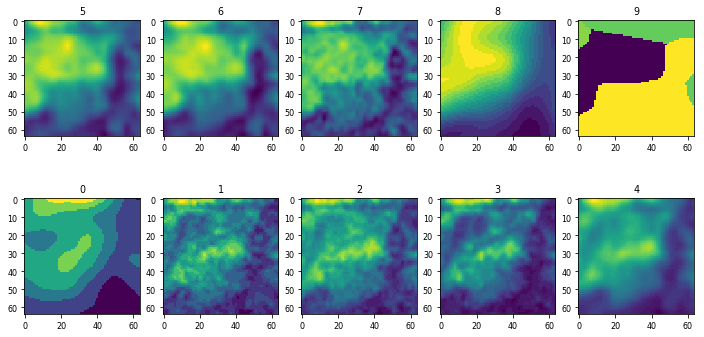

In [27]:
fig = plt.figure(figsize = (12,12))
a = fig.add_subplot(1, 5, 1)
imgplot = plt.imshow(img_tmp[:,:,0])
a.set_title('0')
a = fig.add_subplot(1, 5, 2)
imgplot = plt.imshow(img_tmp[:,:,1])
a.set_title('1')
a = fig.add_subplot(1, 5, 3)
imgplot = plt.imshow(img_tmp[:,:,2])
a.set_title('2')
a = fig.add_subplot(1, 5, 4)
imgplot = plt.imshow(img_tmp[:,:,3])
a.set_title('3')
a = fig.add_subplot(1, 5, 5)
imgplot = plt.imshow(img_tmp[:,:,4])
a.set_title('4')

a = fig.add_subplot(2, 5, 1)
imgplot = plt.imshow(img_tmp[:,:,5])
a.set_title('5')
a = fig.add_subplot(2, 5, 2)
imgplot = plt.imshow(img_tmp[:,:,6])
a.set_title('6')
a = fig.add_subplot(2, 5, 3)
imgplot = plt.imshow(img_tmp[:,:,7])
a.set_title('7')
a = fig.add_subplot(2, 5, 4)
imgplot = plt.imshow(img_tmp[:,:,8])
a.set_title('8')
a = fig.add_subplot(2, 5, 5)
imgplot = plt.imshow(img_tmp[:,:,-1])
a.set_title('9')

Text(0.5,1,'B')

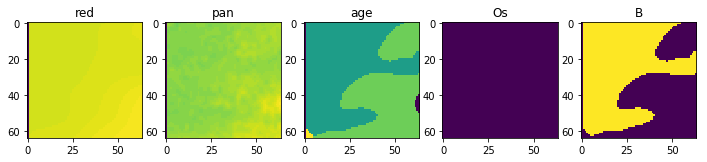

In [61]:
fig = plt.figure(figsize = (12,12))
a = fig.add_subplot(1, 5, 1)
imgplot = plt.imshow(img_tmp[:,:,0])
a.set_title('red')
a = fig.add_subplot(1, 5, 2)
imgplot = plt.imshow(img_tmp[:,:,1])
a.set_title('pan')
a = fig.add_subplot(1, 5, 3)
imgplot = plt.imshow(img_tmp[:,:,-1])
a.set_title('age')
a = fig.add_subplot(1, 5, 4)
imgplot = plt.imshow(mask_tmp[:,:,0])
a.set_title('Os')
a = fig.add_subplot(1, 5, 5)
imgplot = plt.imshow(mask_tmp[:,:,1])
a.set_title('B')

In [69]:
def train_gen(batch_size=32):
    while(True):
        imgarr=[]
        maskarr=[]
        for i in range(batch_size):
            if random.uniform(0, 1) > 0.4:
                if random.uniform(0, 1) > 0.75:
                    rnd_id=len(train_img_list)-1
                elif random.uniform(0, 1) > 0.5:
                    rnd_id=len(train_img_list)-2
                else:
                    rnd_id=len(train_img_list)-3
            else:
                rnd_id=random.randint(0,len(train_img_list)-4)
            img,mask=get_img_mask_array(train_img_list[rnd_id], num_channels)
            imgarr.append(img)
            maskarr.append(mask)
        yield (np.asarray(imgarr),np.asarray(maskarr))
        imgarr=[]
        maskarr=[] 

In [95]:
def train_gen(batch_size=32):
    while(True):
        imgarr=[]
        maskarr=[]
        for i in range(batch_size):
            if random.uniform(0, 1) > 0.3:
                '''
                if random.uniform(0, 1) > 0.75: krasnoborsk, nov nov
                    rnd_id=len(train_img_list)-1
                elif random.uniform(0, 1) > 0.5:
                    rnd_id=len(train_img_list)-2
                else:
                    rnd_id=len(train_img_list)-3 #len(train_img_list), len(train_img_list)-12
                '''
                rnd_id=random.randint(len(train_img_list)-12,len(train_img_list)-1)
            else:
                rnd_id=random.randint(0,len(train_img_list)-13)
            img,mask=get_img_mask_array(train_img_list[rnd_id], num_channels)
            imgarr.append(img)
            maskarr.append(mask)
        yield (np.asarray(imgarr),np.asarray(maskarr))
        imgarr=[]
        maskarr=[] 

In [42]:
def train_gen(batch_size=32):
    while(True):
        imgarr=[]
        maskarr=[]
        for i in range(batch_size):
            rnd_id=random.randint(0,len(train_img_list)-1)
            img,mask=get_img_mask_array(train_img_list[rnd_id], num_channels, class_name=class_name)
            
            imgarr.append(img)
            maskarr.append(mask)
            
        yield (np.asarray(imgarr),np.asarray(maskarr))
        imgarr=[]
        maskarr=[]

In [43]:
def val_gen(batch_size=32):
    while(True):
        imgarr=[]
        maskarr=[]
        for i in range(batch_size):
            rnd_id=random.randint(0,len(val_img_list)-1)
            img,mask=get_img_mask_array(val_img_list[rnd_id], num_channels, class_name=class_name)
            
            imgarr.append(img)
            maskarr.append(mask)
            
        yield (np.asarray(imgarr),np.asarray(maskarr))
        imgarr=[]
        maskarr=[]

In [ ]:
num_channels=8
for img, mask in train_gen():
    print(img)
    break

In [30]:
import keras.backend as K
import tensorflow as tf
import numpy as np
import math

def weighted_categorical_crossentropy(weights):
    """ weighted_categorical_crossentropy

        Args:
            * weights<ktensor|nparray|list>: crossentropy weights
        Returns:
            * weighted categorical crossentropy function
    
    if isinstance(weights,list) or isinstance(weights, np.ndarray):
        weights=K.variable(weights)

    def loss(target,output,from_logits=False):
        if not from_logits:
            output /= tf.reduce_sum(output,
                                    len(output.get_shape()) - 1,
                                    True)
            _epsilon = tf.convert_to_tensor(K.epsilon(), dtype=output.dtype.base_dtype)
            output = tf.clip_by_value(output, _epsilon, 1. - _epsilon)
            weighted_losses = target * tf.log(output) * weights
            return - tf.reduce_sum(weighted_losses,len(output.get_shape()) - 1)
        else:
            raise ValueError('WeightedCategoricalCrossentropy: not valid with logits')
    """
    
    def loss(target,output,from_logits=False):
        output /= tf.reduce_sum(output,
                                len(output.get_shape()) - 1,
                                True)
        non_zero_pixels = tf.reduce_sum(target, axis=-1)
        _epsilon = tf.convert_to_tensor(K.epsilon(), dtype=output.dtype.base_dtype)
        output = tf.clip_by_value(output, _epsilon, 1. - _epsilon)
        weighted_losses = target * tf.log(output) * weights
        return - tf.reduce_sum(weighted_losses,len(output.get_shape()) - 1) * (64*64*batch_size) / K.sum(non_zero_pixels)
  
    return loss
    

# labels_dict : {ind_label: count_label}
# mu : parameter to tune 

def create_class_weight(labels_dict,mu=0.15):
    total = np.sum(list(labels_dict.values()))
    keys = labels_dict.keys()
    class_weight = dict()
    weights_list = np.zeros((len(keys)))
    for key in keys:
        score = math.log(mu*total/float(labels_dict[key]))
        #score = mu*total/float(labels_dict[key])
        class_weight[key] = score if score > 1.0 else 1.0
        weights_list[sorted(keys).index(key)] = class_weight[key]
    return class_weight, weights_list

In [23]:
labels_dict = {'0': 16354+1676, '1': 29975+3485}
class_weight, weights_list = create_class_weight(labels_dict, mu=0.8)
weights_list

array([1., 1.])

aspen:  886632 0.172

birch:  1385786 0.268

pine:  993156 0.192

spruce:  1901716 0.368

~~~~~~~~~~~~~~~~~~~~~~~~~

deciduous:  2272418 0.44

conifer:  2894872 0.56

In [24]:
weights_list = [ 5.8, 1.] # aspen

In [130]:
weights_list = [ 3.7, 1.] # birch

In [35]:
weights_list = [ 2.7, 1.] # spruce

In [ ]:
weights_list = [ 5.2, 1.] # pine

### For aspen

In [131]:
val_img_list_tmp  = []
for i in range(len(val_img_list)):
    tmp = (tiff.imread(val_img_list[i] + '_class_B.tif')>0.5)
    tmp += (tiff.imread(val_img_list[i] + '_class_Os.tif')>0.5)
    if np.sum(tmp) > 7000:
        #print(np.sum(tmp))
        val_img_list_tmp += [val_img_list[i]]

In [132]:
len(val_img_list_tmp), len(val_img_list)

(14, 16)

In [133]:
train_img_list_tmp  = []
for i in range(len(train_img_list)):
    tmp = (tiff.imread(train_img_list[i] + '_class_B.tif')>0.5)
    tmp += (tiff.imread(train_img_list[i] + '_class_Os.tif')>0.5)
    if np.sum(tmp) > 7000:
        #print(np.sum(tmp))
        train_img_list_tmp += [train_img_list[i]]

In [134]:
len(train_img_list_tmp), len(train_img_list)

(72, 82)

In [135]:
train_img_list = train_img_list_tmp
val_img_list = val_img_list_tmp

### Continue

In [46]:
from keras import backend as K
from keras.layers import Conv2D
from keras import layers
from keras.models import Model
import tensorflow as tf
num_channels = 13+age_flag
batch_size = 64
class_name = 'E'
model = Unet(backbone_name='resnet34', input_shape=(None, None, num_channels), classes=2,
                  encoder_weights=None, activation='softmax')
loss =  weighted_categorical_crossentropy(weights_list)  
opt = Adam(lr=0.001)
metrics=[loss]
model.compile(optimizer=opt, loss=loss, metrics=metrics)

In [ ]:
save_dir = '/home/user/data/example/data/Forestry_inventory/conifer_deciduous/'

# csv logger
log_filename = os.path.join(save_dir, '{}_versus_all.csv'.format(class_name))
csv_logger = CSVLogger(log_filename, separator=',', append='True')

callbacks=[
    ReduceLROnPlateau(patience=5,min_lr=1e-9,verbose=1,mode='min'), #pat 7
    ModelCheckpoint(save_dir + '{}_versus_all.h5'.format(class_name),save_best_only=True,verbose=1),
    ModelCheckpoint(save_dir + '{}_versus_all.hdf5'.format(class_name),save_best_only=True,verbose=1, save_weights_only=True)
]

history=model.fit_generator(train_gen(batch_size),epochs=20, #35, 25 20
                           steps_per_epoch=100,
                           validation_data=val_gen(batch_size),  #(valid_imgarr,valid_maskarr),
                           callbacks=callbacks, validation_steps=30)

Epoch 1/20
100/100 [==============================] - 1320s 13s/step - loss: 0.7266 - loss_1: 0.7266 - val_loss: 0.6301 - val_loss_1: 0.6301

Epoch 00001: val_loss improved from inf to 0.63007, saving model to /home/user/data/example/data/Forestry_inventory/conifer_deciduous/E_versus_all.h5

Epoch 00001: val_loss improved from inf to 0.63007, saving model to /home/user/data/example/data/Forestry_inventory/conifer_deciduous/E_versus_all.hdf5
Epoch 2/20
 36/100 [=========>....................] - ETA: 9:34 - loss: 0.5970 - loss_1: 0.5970

In [50]:
metric_4cl(model, num_cl = 2)

0 : precision  0.7107  recall  0.83655  f1  0.7685
 
1 : precision  0.91868  recall  0.84431  f1  0.87993
 


In [102]:
metric_4cl(model, num_cl = 2) 

0 : precision  0.97331  recall  0.64757  f1  0.77771
 
1 : precision  0.69534  recall  0.9784  f1  0.81293
 


In [105]:
metric_4cl(model, num_cl = 2) 

0 : precision  0.981  recall  0.64561  f1  0.77873
 
1 : precision  0.69554  recall  0.98479  f1  0.81527
 


In [79]:
metric_4cl(model, num_cl = 2) 

0 : precision  0.75099  recall  0.86183  f1  0.8026
 
1 : precision  0.89882  recall  0.81114  f1  0.85273
 


In [104]:
model.load_weights("/home/user/data/example/data/Forestry_inventory/conifer_deciduous/con_sentinel_all.h5")

In [77]:
# serialize model to JSON without height
model_json = model.to_json()
with open(save_dir+"cd_sentinel_all_best_2.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights(save_dir+"cd_sentinel_all_best_2.h5")
print("Saved model to disk")

Saved model to disk


In [68]:
# serialize model to JSON
model_json = model.to_json()
with open(save_dir+"cd_sentinel_all_best_1.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights(save_dir+"cd_sentinel_all_best_1.h5")
print("Saved model to disk")

Saved model to disk


In [106]:
# serialize model to JSON
model_json = model.to_json()
with open(save_dir+"con_sentinel_all_best_1.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights(save_dir+"con_sentinel_all_best_1.h5")
print("Saved model to disk")

Saved model to disk


In [46]:
# serialize model to JSON
model_json = model.to_json()
with open(save_dir+".json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights(save_dir+".h5")
print("Saved model to disk")

Saved model to disk


In [171]:
model.load_weights("/home/user/data/example/data/Forestry_inventory/conifer_deciduous/tmp_sentinel.hdf5")

In [52]:
test_img_list

['/home/user/data/EO_Browser_images/0/5_6',
 '/home/user/data/EO_Browser_images/0/6_4',
 '/home/user/data/EO_Browser_images/0/4_8',
 '/home/user/data/EO_Browser_images/0/4_3',
 '/home/user/data/EO_Browser_images/0/3_2',
 '/home/user/data/EO_Browser_images/0/4_7',
 '/home/user/data/EO_Browser_images/0/7_6',
 '/home/user/data/EO_Browser_images/0/1_0',
 '/home/user/data/EO_Browser_images/1/5_6',
 '/home/user/data/EO_Browser_images/1/6_4',
 '/home/user/data/EO_Browser_images/1/4_8',
 '/home/user/data/EO_Browser_images/1/4_3',
 '/home/user/data/EO_Browser_images/1/3_2',
 '/home/user/data/EO_Browser_images/1/4_7',
 '/home/user/data/EO_Browser_images/1/7_6',
 '/home/user/data/EO_Browser_images/1/1_0']

***
***

# Evaluation

In [150]:
for img, mask in val_gen():
    break
pred = model.predict(img)

/opt/conda/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


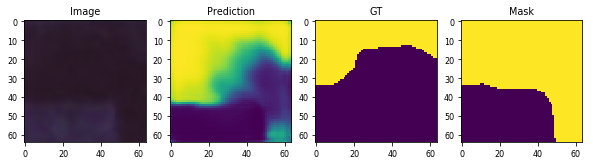

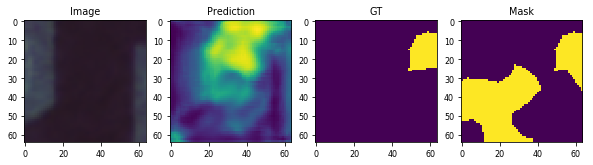

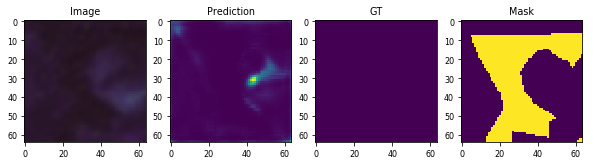

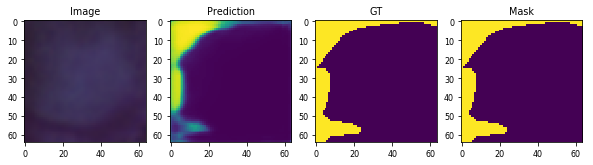

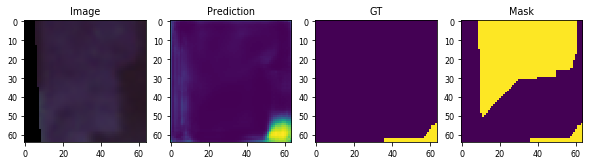

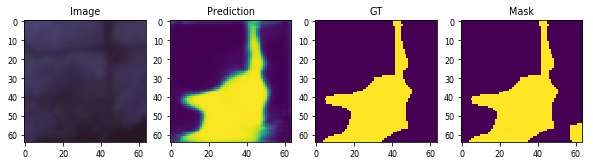

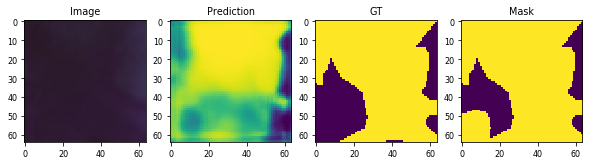

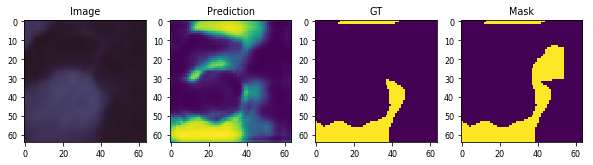

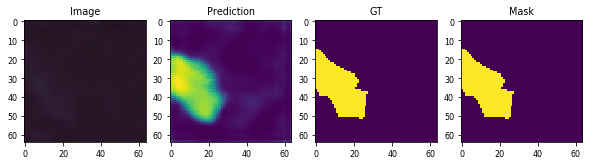

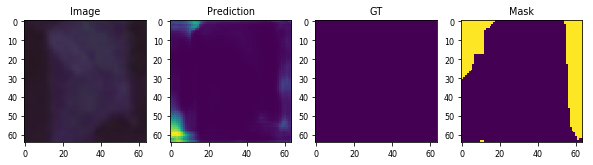

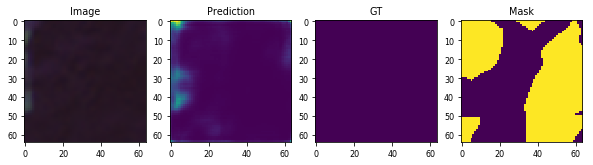

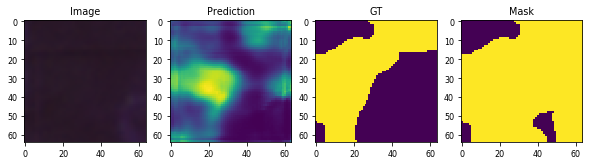

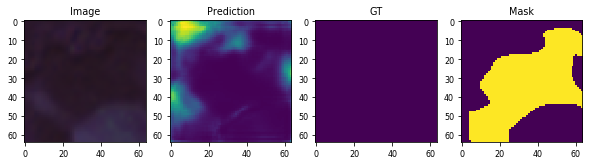

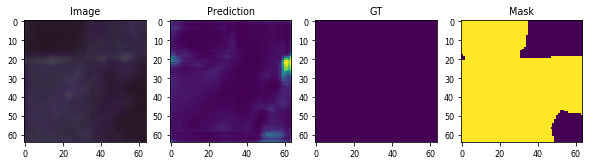

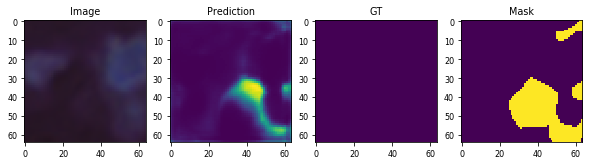

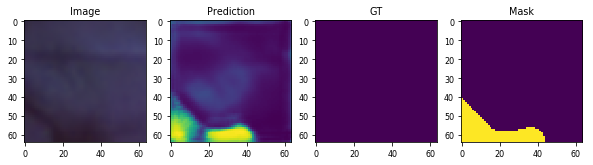

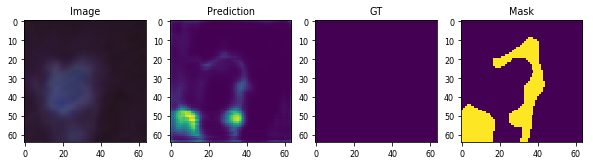

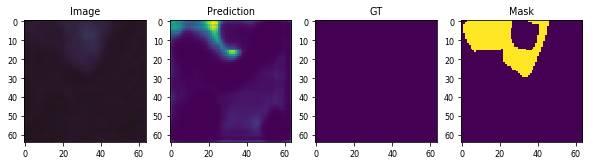

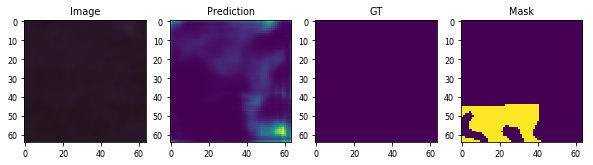

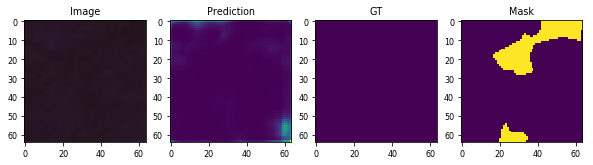

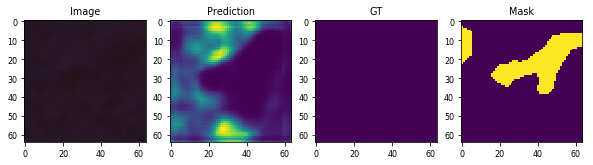

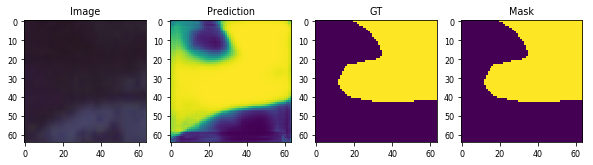

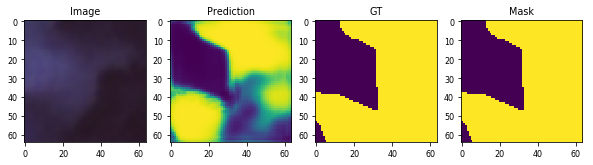

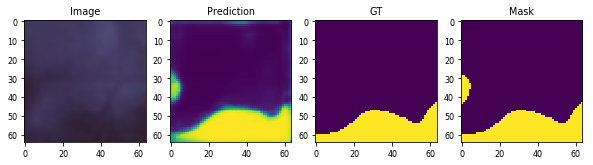

In [151]:
cl=1
for num in range(1, 25):
    fig = plt.figure(figsize=(10, 10))
    a = fig.add_subplot(1, 4, 1)
    a.set_title('Image')
    imgplot = plt.imshow(img[num, :, :, 2:5])
    a = fig.add_subplot(1, 4, 2)
    a.set_title('Prediction')
    imgplot = plt.imshow(pred[num,:,:,1])#np.where(np.argmax(pred[num,:,:,:], axis=2)==cl, 1, 0)*np.where(np.sum(mask[num,:,:,:], axis=2)>0, 1, 0)) #.imshow(pred[num,:,:,cl]>0.5) 
    a = fig.add_subplot(1, 4, 3)
    a.set_title('GT')
    imgplot = plt.imshow(mask[num,:,:,cl])

    a = fig.add_subplot(1, 4, 4)
    a.set_title('Mask')
    imgplot = plt.imshow(np.where(np.sum(mask[num,:,:,:], axis=2)>0, 1, 0))

In [100]:
def get_img_mask_array_val(imgpath, num_channels=13, num_classes=2):
    with rasterio.open(imgpath + '_channel_01.tif') as src:
        size_x = src.width
        size_y = src.height
    
    img = np.ones((size_y, size_x, num_channels), dtype=np.uint8)
    #read channels
    for i in range(num_channels-1-age_flag): #-2
        i_ch = i + 1
        if i < 9:
            i_ch = '0'+str(i+1)
        with rasterio.open(imgpath+ '_channel_{}.tif'.format(i_ch)) as src:
            src.read(1, img[:,:,i])
            #img[:,:,-1] = src.read(1)
    
    with rasterio.open(imgpath+ '_channel_{}.tif'.format('8A')) as src:
        src.read(1, img[:,:,-1-age_flag]) #-2
    img = img.astype(np.float)   
    img /= 255.
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # AGE
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    if age_flag:
        channel_name = '_age.tif'
        with rasterio.open(imgpath + channel_name) as src:
            img[:,:,-1] = src.read(1).astype(np.float)
        img[:,:,-1] = (img[:,:,-1] / 100.).clip(0., 1.)

    #read classes 
    mask = np.zeros((img.shape[0], img.shape[1], num_classes)) 
    with rasterio.open(imgpath + '_class_Os.tif') as src:
        mask_0 = src.read(1).astype(np.float)
    with rasterio.open(imgpath + '_class_B.tif') as src:
        mask_1 = src.read(1).astype(np.float)
    with rasterio.open(imgpath + '_class_E.tif') as src:
        mask_2 = src.read(1).astype(np.float)
    with rasterio.open(imgpath + '_class_S.tif') as src:
        mask_3 = src.read(1).astype(np.float)    
     
    # conifer / deciduous
    mask_conifer = mask_2 + mask_3
    mask_deciduous = mask_0 + mask_1 
    for i in range(num_classes):
        mask[:,:,i] = np.where(np.argmax([mask_conifer, mask_deciduous], axis=0)==i, 1, 0) \
            * np.where(np.sum([mask_conifer, mask_deciduous], axis=0) != 0, 1, 0) 
    
    # aspen / birch
    mask[:,:,0] = np.where(mask_2>0.5, 1, 0) #0, 2
    mask[:,:,1] = np.where(mask_3>0.5, 1, 0) #1, 3
    return np.asarray(img), np.asarray(mask)

In [48]:
def get_img_mask_array_val(imgpath, num_channels=13, num_classes=2):
    with rasterio.open(imgpath + '_channel_01.tif') as src:
        size_x = src.width
        size_y = src.height
    
    img = np.ones((size_y, size_x, num_channels), dtype=np.uint8)
    #read channels
    for i in range(num_channels-1-age_flag): #-2
        i_ch = i + 1
        if i < 9:
            i_ch = '0'+str(i+1)
        with rasterio.open(imgpath+ '_channel_{}.tif'.format(i_ch)) as src:
            src.read(1, img[:,:,i])
            #img[:,:,-1] = src.read(1)
    
    with rasterio.open(imgpath+ '_channel_{}.tif'.format('8A')) as src:
        src.read(1, img[:,:,-1-age_flag]) #-2
    img = img.astype(np.float)   
    img /= 255.
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # AGE
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    if age_flag:
        channel_name = '_age.tif'
        with rasterio.open(imgpath + channel_name) as src:
            img[:,:,-1] = src.read(1).astype(np.float)
        img[:,:,-1] = (img[:,:,-1] / 100.).clip(0., 1.)

    #read classes 
    mask = np.zeros((img.shape[0], img.shape[1], num_classes)) 
    with rasterio.open(imgpath + '_class_{}.tif'.format(class_name)) as src:
        mask_0 = src.read(1).astype(np.float) > 0.5
    
    mask_1 = np.zeros((mask_0.shape))
    for cl_name in ['Os', 'B', 'E', 'S']:
        if cl_name == class_name:
            continue
        else:
            with rasterio.open(imgpath + '_class_{}.tif'.format(cl_name)) as src:
                mask_1 += (src.read(1).astype(np.float)>0.5)
                
    mask[:,:,0] = mask_0 
    mask[:,:,1] = mask_1 
    return np.asarray(img), np.asarray(mask)

In [49]:
def metric_4cl(model, num_cl = 2):
    
    TP = np.zeros((num_cl), dtype=int)
    TN = np.zeros((num_cl), dtype=int)
    FN = np.zeros((num_cl), dtype=int)
    FP = np.zeros((num_cl), dtype=int)
    
    imgarr=[]
    maskarr=[]
    for id_elem in range(len(val_img_list)): #val_img_list
        img,mask=get_img_mask_array_val(val_img_list[id_elem], num_channels=13+age_flag) #val_img_list
        size_x, size_y, _ = img.shape
        for i in range(0, int(size_x / IMG_ROW)):
            for j in range(0, int(size_y / IMG_COL)):
                imgarr.append(img[i*IMG_ROW:i*IMG_ROW + IMG_ROW, j*IMG_COL:j*IMG_COL + IMG_COL])
                maskarr.append(mask[i*IMG_ROW:i*IMG_ROW + IMG_ROW, j*IMG_COL:j*IMG_COL + IMG_COL])
                #forestarr.append(mask_forest[i*IMG_ROW:i*IMG_ROW + IMG_ROW, j*IMG_COL:j*IMG_COL + IMG_COL])
    
    imgarr = np.asarray(imgarr)
    #forestarr = np.asarray(forestarr)
    maskarr = np.asarray(maskarr)#*forestarr
    pred = model.predict(imgarr)#*forestarr
    precision = np.zeros((num_cl))
    recall = np.zeros((num_cl))
    accuracy = np.zeros((num_cl))
    f1_cl = np.zeros((num_cl))
    
    for cl in range(num_cl):
        gt = np.where(maskarr[:,:,:,cl] == 1, 1, 0) * np.sum(maskarr, axis=3) #np.sum(maskarr, axis=3)
        pr_cl = np.sum(maskarr, axis=3)*np.where(np.argmax(pred, axis=3)==cl, 1, 0)
        TP[cl] += np.sum(pr_cl * gt)
        FP[cl] += np.sum(pr_cl * np.where(gt==0, 1, 0)*np.sum(maskarr, axis=3))
        FN[cl] += np.sum(np.where(pr_cl==0, 1, 0) * gt )
        TN[cl] += np.sum(np.where(pr_cl==0, 1, 0) * np.where(gt==0, 1, 0)*np.sum(maskarr, axis=3))
    #print(FN)
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    accuracy = (TP + TN) / (TP + TN + FP + FN) 
    f1_cl = 2*((precision*recall)/(precision+recall))

    classes = ['0', '1', '2','4' ]
    for i in range(num_cl):
        print(classes[i], ': precision ', round(precision[i], 5), ' recall ', round(recall[i], 5), ' f1 ', round(f1_cl[i], 5))
        print(' ')
    #return maskarr,pred 

In [35]:
def total_accuracy(model, num_cl = 2):
    
    imgarr=[]
    maskarr=[]
    forestarr=[]
    for id_elem in range(len(val_img_list)): 
        img,mask,mask_forest=get_img_mask_array_val(val_img_list[id_elem])
        size_x, size_y, _ = img.shape
        for i in range(0, int(size_x / IMG_ROW)):
            for j in range(0, int(size_y / IMG_COL)):
                imgarr.append(img[i*IMG_ROW:i*IMG_ROW + IMG_ROW, j*IMG_COL:j*IMG_COL + IMG_COL])
                maskarr.append(mask[i*IMG_ROW:i*IMG_ROW + IMG_ROW, j*IMG_COL:j*IMG_COL + IMG_COL])
                #forestarr.append(mask_forest[i*IMG_ROW:i*IMG_ROW + IMG_ROW, j*IMG_COL:j*IMG_COL + IMG_COL])
    
    imgarr = np.asarray(imgarr)
    maskarr = np.asarray(maskarr)
    pred = model.predict(imgarr)
    
    total_accuracy = np.sum(maskarr*np.where(pred>0.5, 1, 0)) / np.sum(maskarr) 
    print(total_accuracy)